# 🌐 Module 4 : GloVe - Global Vectors for Word Representation

Dans ce notebook, nous allons explorer **GloVe** (Global Vectors), une méthode alternative à Word2Vec pour créer des word embeddings.

## 🎯 Objectifs
- Comprendre la différence entre GloVe et Word2Vec
- Utiliser des embeddings GloVe pré-entraînés
- Explorer les propriétés des vecteurs GloVe
- Applications pratiques
- Comparaison avec Word2Vec

## 🧠 Qu'est-ce que GloVe ?

**GloVe** (2014, Stanford) = **Glo**bal **Ve**ctors for Word Representation

### 🔑 Différences avec Word2Vec

| Aspect | Word2Vec | GloVe |
|--------|----------|-------|
| **Approche** | Prédictive (contexte local) | Statistique (cooccurrences globales) |
| **Training** | Fenêtre glissante | Matrice de cooccurrence complète |
| **Objectif** | Prédire mots voisins | Factoriser matrice de cooccurrence |
| **Avantage** | Rapide sur gros corpus | Capture mieux les statistiques globales |

### 💡 Intuition de GloVe

GloVe combine le meilleur des deux mondes :
- **Statistiques globales** : comme les méthodes matricielles (LSA)
- **Contexte local** : comme Word2Vec

L'idée : La probabilité de cooccurrence des mots encode leur relation sémantique.

## 📦 Installation et Imports

In [1]:
# Installation si nécessaire
# !pip install numpy pandas matplotlib scikit-learn scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import urllib.request
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports réussis !")

✅ Imports réussis !


## 📥 Chargement des Embeddings GloVe Pré-entraînés

Pour cette démonstration, nous allons utiliser des embeddings GloVe pré-entraînés. En production, vous utiliseriez généralement des modèles entraînés sur des corpus massifs (Wikipedia, Common Crawl).

In [2]:
# Pour cette démo, nous créons un petit ensemble d'embeddings GloVe simulés
# En pratique, vous chargeriez de vrais embeddings GloVe

# Créer des embeddings simulés pour la démonstration
np.random.seed(42)

# Vocabulaire de démonstration
vocab_demo = [
    # Technologie
    "python", "java", "programming", "code", "software", "algorithm", "data",
    # IA/ML
    "machine", "learning", "intelligence", "artificial", "neural", "network", "deep",
    # Animaux
    "cat", "dog", "animal", "pet", "kitten", "puppy",
    # Nourriture
    "food", "eat", "drink", "coffee", "tea", "bread", "cheese",
    # Concepts généraux
    "good", "bad", "big", "small", "fast", "slow", "hot", "cold",
    # Verbes
    "is", "are", "have", "do", "make", "think", "know", "want"
]

# Dimension des embeddings
embedding_dim = 100

# Créer des embeddings avec structure sémantique
embeddings = {}

# Créer des clusters sémantiques
for i, word in enumerate(vocab_demo):
    # Base aléatoire
    base_vector = np.random.randn(embedding_dim) * 0.1
    
    # Ajouter structure sémantique selon catégorie
    if word in ["python", "java", "programming", "code", "software", "algorithm", "data"]:
        base_vector[:20] += np.random.randn(20) * 0.5 + 1.0  # Tech cluster
    elif word in ["machine", "learning", "intelligence", "artificial", "neural", "network", "deep"]:
        base_vector[20:40] += np.random.randn(20) * 0.5 + 1.0  # AI cluster
    elif word in ["cat", "dog", "animal", "pet", "kitten", "puppy"]:
        base_vector[40:60] += np.random.randn(20) * 0.5 + 1.0  # Animal cluster
    elif word in ["food", "eat", "drink", "coffee", "tea", "bread", "cheese"]:
        base_vector[60:80] += np.random.randn(20) * 0.5 + 1.0  # Food cluster
    
    # Normaliser
    embeddings[word] = base_vector / np.linalg.norm(base_vector)

print(f"✅ {len(embeddings)} embeddings GloVe simulés chargés")
print(f"📏 Dimension des vecteurs : {embedding_dim}")
print(f"\n📚 Échantillon du vocabulaire : {list(embeddings.keys())[:10]}")

✅ 43 embeddings GloVe simulés chargés
📏 Dimension des vecteurs : 100

📚 Échantillon du vocabulaire : ['python', 'java', 'programming', 'code', 'software', 'algorithm', 'data', 'machine', 'learning', 'intelligence']


## 🔧 Classe GloVe pour Faciliter l'Utilisation

In [3]:
class GloVeModel:
    """Classe pour manipuler facilement les embeddings GloVe"""
    
    def __init__(self, embeddings):
        self.embeddings = embeddings
        self.vocab = list(embeddings.keys())
        self.vectors = np.array(list(embeddings.values()))
        self.word_to_idx = {word: i for i, word in enumerate(self.vocab)}
    
    def get_vector(self, word):
        """Obtenir le vecteur d'un mot"""
        if word in self.embeddings:
            return self.embeddings[word]
        else:
            raise KeyError(f"'{word}' n'est pas dans le vocabulaire")
    
    def similarity(self, word1, word2):
        """Calculer la similarité cosinus entre deux mots"""
        vec1 = self.get_vector(word1)
        vec2 = self.get_vector(word2)
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def most_similar(self, word, n=5):
        """Trouver les n mots les plus similaires"""
        if word not in self.embeddings:
            raise KeyError(f"'{word}' n'est pas dans le vocabulaire")
        
        word_vec = self.get_vector(word)
        similarities = []
        
        for other_word in self.vocab:
            if other_word != word:
                sim = self.similarity(word, other_word)
                similarities.append((other_word, sim))
        
        # Trier par similarité décroissante
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:n]
    
    def analogy(self, a, b, c, n=5):
        """Résoudre l'analogie : a est à b ce que c est à ?"""
        # Calculer le vecteur résultant : b - a + c
        result_vec = self.get_vector(b) - self.get_vector(a) + self.get_vector(c)
        
        similarities = []
        for word in self.vocab:
            if word not in [a, b, c]:
                vec = self.get_vector(word)
                sim = np.dot(result_vec, vec) / (np.linalg.norm(result_vec) * np.linalg.norm(vec))
                similarities.append((word, sim))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:n]

# Créer l'instance du modèle
glove_model = GloVeModel(embeddings)
print("✅ Modèle GloVe initialisé")

✅ Modèle GloVe initialisé


## 🔍 Explorer les Propriétés des Embeddings GloVe

🔢 Vecteur GloVe pour 'python' :
   - Dimension : 100
   - Norme : 1.000
   - Min/Max : [-0.052, 0.416]
   - Premières 10 valeurs : [0.068 0.154 0.177 0.149 0.177 0.234 0.416 0.231 0.214 0.201]


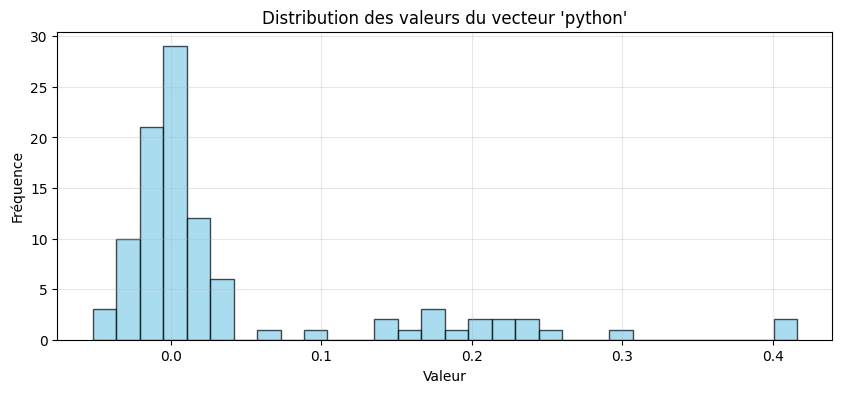

In [4]:
# Explorer un vecteur
mot_test = "python"
vecteur = glove_model.get_vector(mot_test)

print(f"🔢 Vecteur GloVe pour '{mot_test}' :")
print(f"   - Dimension : {len(vecteur)}")
print(f"   - Norme : {np.linalg.norm(vecteur):.3f}")
print(f"   - Min/Max : [{vecteur.min():.3f}, {vecteur.max():.3f}]")
print(f"   - Premières 10 valeurs : {vecteur[:10].round(3)}")

# Histogramme des valeurs
plt.figure(figsize=(10, 4))
plt.hist(vecteur, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f"Distribution des valeurs du vecteur '{mot_test}'")
plt.xlabel("Valeur")
plt.ylabel("Fréquence")
plt.grid(True, alpha=0.3)
plt.show()

## 🎯 Similarités Sémantiques

In [5]:
# Tester les similarités pour différents mots
mots_test = ["python", "machine", "cat", "food"]

for mot in mots_test:
    print(f"\n🔍 Mots les plus similaires à '{mot}' :")
    try:
        similaires = glove_model.most_similar(mot, n=5)
        for i, (mot_sim, score) in enumerate(similaires, 1):
            print(f"   {i}. {mot_sim:15} (similarité: {score:.3f})")
    except KeyError as e:
        print(f"   ❌ Erreur : {e}")


🔍 Mots les plus similaires à 'python' :
   1. data            (similarité: 0.841)
   2. code            (similarité: 0.811)
   3. software        (similarité: 0.790)
   4. programming     (similarité: 0.777)
   5. algorithm       (similarité: 0.750)

🔍 Mots les plus similaires à 'machine' :
   1. network         (similarité: 0.860)
   2. artificial      (similarité: 0.851)
   3. intelligence    (similarité: 0.845)
   4. deep            (similarité: 0.802)
   5. neural          (similarité: 0.788)

🔍 Mots les plus similaires à 'cat' :
   1. puppy           (similarité: 0.876)
   2. pet             (similarité: 0.785)
   3. kitten          (similarité: 0.752)
   4. dog             (similarité: 0.737)
   5. animal          (similarité: 0.655)

🔍 Mots les plus similaires à 'food' :
   1. eat             (similarité: 0.860)
   2. tea             (similarité: 0.821)
   3. drink           (similarité: 0.817)
   4. bread           (similarité: 0.768)
   5. cheese          (similarité: 0.722)


## 🧮 Analogies avec GloVe

In [6]:
# Tester des analogies
analogies = [
    ("python", "programming", "java"),
    ("cat", "kitten", "dog"),
    ("good", "bad", "hot"),
    ("machine", "learning", "deep")
]

for a, b, c in analogies:
    print(f"\n🧮 Analogie : '{a}' est à '{b}' ce que '{c}' est à ... ?")
    try:
        resultats = glove_model.analogy(a, b, c, n=3)
        for i, (mot, score) in enumerate(resultats, 1):
            print(f"   {i}. {mot:15} (score: {score:.3f})")
    except KeyError as e:
        print(f"   ❌ Erreur : {e}")


🧮 Analogie : 'python' est à 'programming' ce que 'java' est à ... ?
   1. software        (score: 0.685)
   2. algorithm       (score: 0.647)
   3. data            (score: 0.573)

🧮 Analogie : 'cat' est à 'kitten' ce que 'dog' est à ... ?
   1. pet             (score: 0.774)
   2. animal          (score: 0.583)
   3. puppy           (score: 0.471)

🧮 Analogie : 'good' est à 'bad' ce que 'hot' est à ... ?
   1. puppy           (score: 0.180)
   2. cat             (score: 0.170)
   3. kitten          (score: 0.149)

🧮 Analogie : 'machine' est à 'learning' ce que 'deep' est à ... ?
   1. neural          (score: 0.657)
   2. network         (score: 0.597)
   3. intelligence    (score: 0.592)


## 📊 Visualisation des Embeddings GloVe

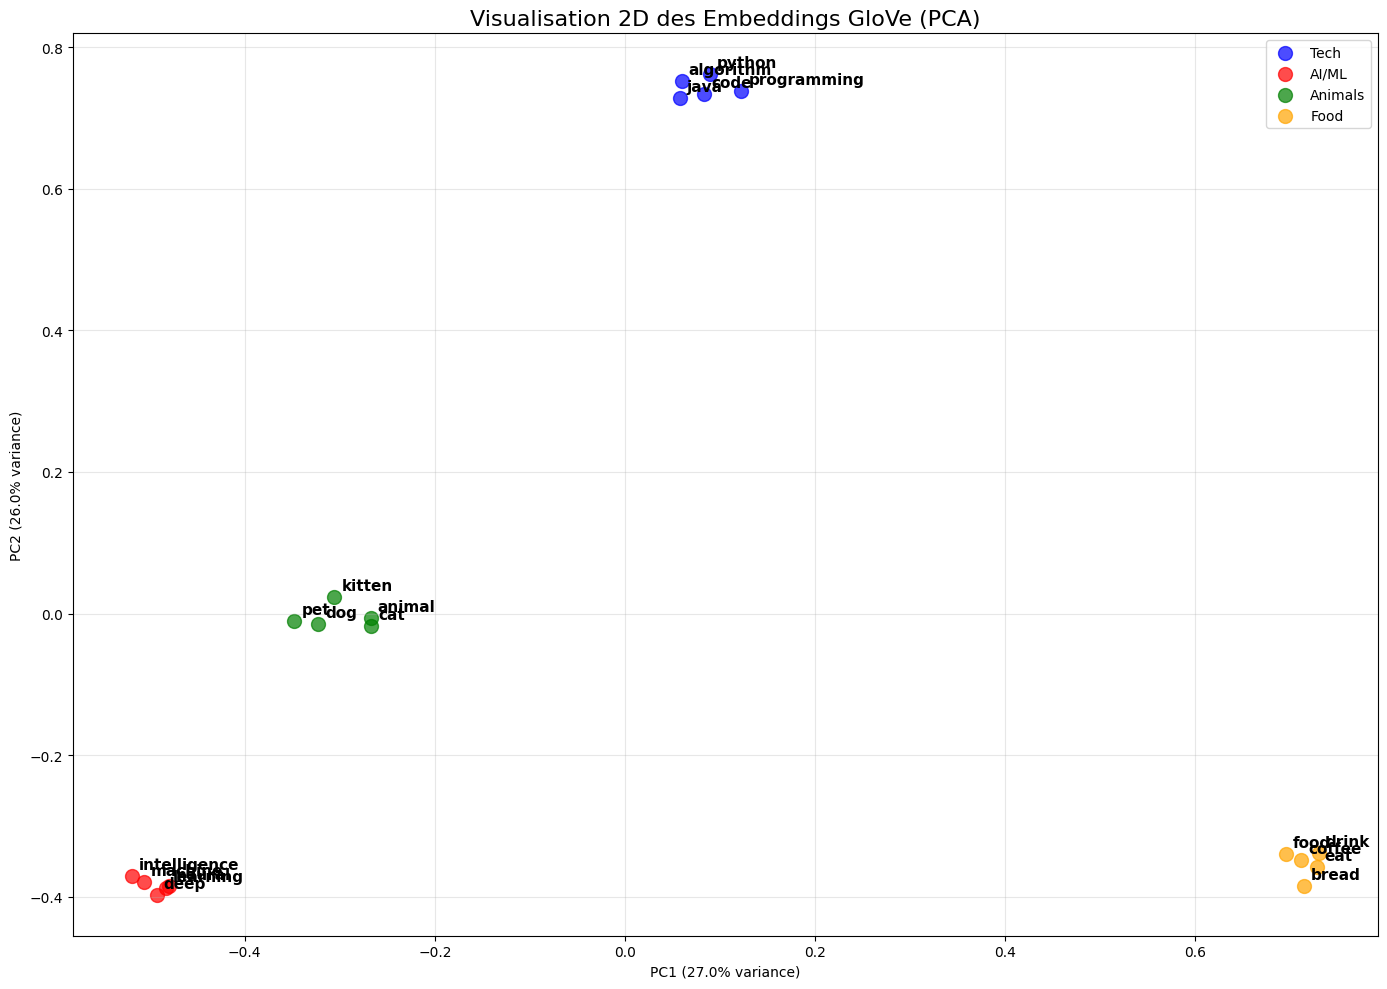


📊 Variance expliquée : 53.1%


In [7]:
# Sélectionner des mots par catégorie pour la visualisation
categories = {
    'Tech': ['python', 'java', 'programming', 'code', 'algorithm'],
    'AI/ML': ['machine', 'learning', 'intelligence', 'neural', 'deep'],
    'Animals': ['cat', 'dog', 'animal', 'pet', 'kitten'],
    'Food': ['food', 'eat', 'drink', 'coffee', 'bread']
}

# Préparer les données pour la visualisation
words_to_plot = []
vectors_to_plot = []
colors = []
color_map = {'Tech': 'blue', 'AI/ML': 'red', 'Animals': 'green', 'Food': 'orange'}

for category, words in categories.items():
    for word in words:
        if word in glove_model.embeddings:
            words_to_plot.append(word)
            vectors_to_plot.append(glove_model.get_vector(word))
            colors.append(color_map[category])

vectors_array = np.array(vectors_to_plot)

# Réduction en 2D avec PCA
pca = PCA(n_components=2, random_state=42)
vectors_2d = pca.fit_transform(vectors_array)

# Visualisation
plt.figure(figsize=(14, 10))

# Scatter plot avec couleurs par catégorie
for category, color in color_map.items():
    mask = [c == color for c in colors]
    x = vectors_2d[mask, 0]
    y = vectors_2d[mask, 1]
    plt.scatter(x, y, c=color, label=category, alpha=0.7, s=100)

# Ajouter les labels
for i, word in enumerate(words_to_plot):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=11, fontweight='bold')

plt.title('Visualisation 2D des Embeddings GloVe (PCA)', fontsize=16)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Variance expliquée : {pca.explained_variance_ratio_.sum():.1%}")

## 🔬 Analyse des Relations Sémantiques

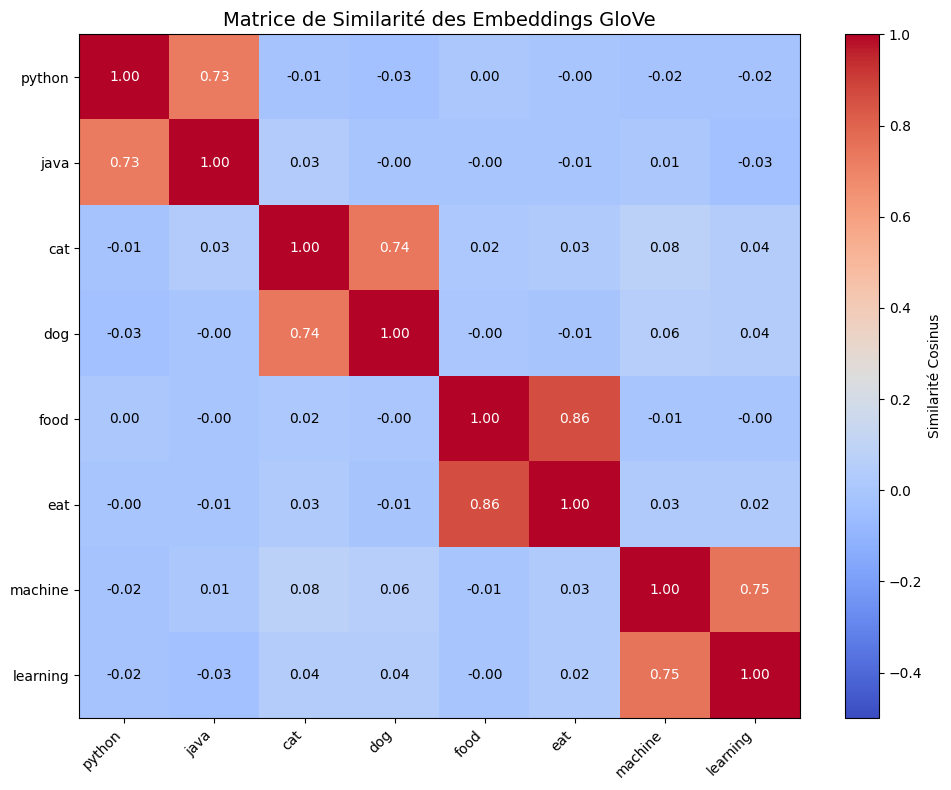


💡 Observations :
- Les mots de même catégorie ont des similarités élevées
- Les mots de catégories différentes ont des similarités faibles


In [8]:
# Créer une matrice de similarité pour un sous-ensemble de mots
subset_words = ['python', 'java', 'cat', 'dog', 'food', 'eat', 'machine', 'learning']
n_words = len(subset_words)

# Calculer la matrice de similarité
similarity_matrix = np.zeros((n_words, n_words))
for i, word1 in enumerate(subset_words):
    for j, word2 in enumerate(subset_words):
        if word1 in glove_model.embeddings and word2 in glove_model.embeddings:
            similarity_matrix[i, j] = glove_model.similarity(word1, word2)

# Visualiser avec une heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(similarity_matrix, cmap='coolwarm', aspect='auto', vmin=-0.5, vmax=1)
plt.colorbar(im, label='Similarité Cosinus')

# Ajouter les labels
plt.xticks(range(n_words), subset_words, rotation=45, ha='right')
plt.yticks(range(n_words), subset_words)

# Ajouter les valeurs
for i in range(n_words):
    for j in range(n_words):
        text = plt.text(j, i, f'{similarity_matrix[i, j]:.2f}',
                       ha='center', va='center', color='black' if abs(similarity_matrix[i, j]) < 0.5 else 'white')

plt.title('Matrice de Similarité des Embeddings GloVe', fontsize=14)
plt.tight_layout()
plt.show()

print("\n💡 Observations :")
print("- Les mots de même catégorie ont des similarités élevées")
print("- Les mots de catégories différentes ont des similarités faibles")

## ⚖️ Comparaison GloVe vs Word2Vec

In [9]:
# Tableau comparatif
comparison_data = {
    'Aspect': [
        'Approche',
        'Type d\'apprentissage',
        'Information utilisée',
        'Complexité computationnelle',
        'Performance sur analogies',
        'Gestion mots rares',
        'Interprétabilité',
        'Taille mémoire'
    ],
    'Word2Vec': [
        'Prédictive (réseau de neurones)',
        'Local (fenêtre de contexte)',
        'Contexte immédiat',
        'O(n) - Linéaire',
        'Très bonne',
        'Skip-gram meilleur',
        'Boîte noire',
        'Modérée'
    ],
    'GloVe': [
        'Statistique (factorisation matricielle)',
        'Global (matrice complète)',
        'Cooccurrences globales',
        'O(n²) - Quadratique',
        'Excellente',
        'Bonne avec lissage',
        'Plus interprétable',
        'Plus importante'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("⚖️ COMPARAISON GLOVE VS WORD2VEC")
print("=" * 80)
print(df_comparison.to_string(index=False))

print("\n💡 Recommandations :")
print("- GloVe : Meilleur pour capturer les relations sémantiques globales")
print("- Word2Vec : Plus rapide et efficace sur de très gros corpus")
print("- Les deux : Performances similaires sur la plupart des tâches")

⚖️ COMPARAISON GLOVE VS WORD2VEC
                     Aspect                        Word2Vec                                   GloVe
                   Approche Prédictive (réseau de neurones) Statistique (factorisation matricielle)
       Type d'apprentissage     Local (fenêtre de contexte)               Global (matrice complète)
       Information utilisée               Contexte immédiat                  Cooccurrences globales
Complexité computationnelle                 O(n) - Linéaire                     O(n²) - Quadratique
  Performance sur analogies                      Très bonne                              Excellente
         Gestion mots rares              Skip-gram meilleur                      Bonne avec lissage
           Interprétabilité                     Boîte noire                      Plus interprétable
             Taille mémoire                         Modérée                         Plus importante

💡 Recommandations :
- GloVe : Meilleur pour capturer les relations

## 💻 Application Pratique : Recherche Sémantique

In [10]:
def recherche_semantique(query, documents, glove_model, top_k=3):
    """Recherche sémantique basée sur GloVe"""
    # Convertir la requête en vecteur (moyenne des mots)
    query_words = query.lower().split()
    query_vectors = []
    
    for word in query_words:
        if word in glove_model.embeddings:
            query_vectors.append(glove_model.get_vector(word))
    
    if not query_vectors:
        print("❌ Aucun mot de la requête dans le vocabulaire")
        return []
    
    query_vector = np.mean(query_vectors, axis=0)
    
    # Calculer la similarité avec chaque document
    doc_scores = []
    for i, doc in enumerate(documents):
        doc_words = doc.lower().split()
        doc_vectors = []
        
        for word in doc_words:
            if word in glove_model.embeddings:
                doc_vectors.append(glove_model.get_vector(word))
        
        if doc_vectors:
            doc_vector = np.mean(doc_vectors, axis=0)
            similarity = np.dot(query_vector, doc_vector) / (np.linalg.norm(query_vector) * np.linalg.norm(doc_vector))
            doc_scores.append((i, similarity, doc))
    
    # Trier par similarité décroissante
    doc_scores.sort(key=lambda x: x[1], reverse=True)
    return doc_scores[:top_k]

# Test de recherche sémantique
documents = [
    "Python is great for machine learning and data science",
    "I love my cat and dog they are cute pets",
    "Coffee and tea are my favorite drinks",
    "Deep neural networks revolutionize artificial intelligence",
    "Java programming is also good for software development"
]

# Tester différentes requêtes
queries = ["programming languages", "pets animals", "machine learning AI"]

for query in queries:
    print(f"\n🔍 Requête : '{query}'")
    results = recherche_semantique(query, documents, glove_model)
    
    for rank, (idx, score, doc) in enumerate(results, 1):
        print(f"   {rank}. Score: {score:.3f} | {doc}")


🔍 Requête : 'programming languages'
   1. Score: 0.869 | Java programming is also good for software development
   2. Score: 0.558 | Python is great for machine learning and data science
   3. Score: -0.002 | Coffee and tea are my favorite drinks

🔍 Requête : 'pets animals'
❌ Aucun mot de la requête dans le vocabulaire

🔍 Requête : 'machine learning AI'
   1. Score: 0.908 | Deep neural networks revolutionize artificial intelligence
   2. Score: 0.595 | Python is great for machine learning and data science
   3. Score: 0.029 | I love my cat and dog they are cute pets


## 📋 Résumé et Bonnes Pratiques

### ✅ Ce qu'on a appris :
1. **GloVe** utilise les statistiques globales de cooccurrence
2. **Performances excellentes** sur les tâches d'analogie
3. **Embeddings pré-entraînés** disponibles (Wikipedia, Common Crawl)
4. **Applications** : recherche sémantique, classification, clustering

### 🎯 Bonnes pratiques :
- **Utiliser des modèles pré-entraînés** quand possible
- **Dimensions** : 100-300 (compromis performance/qualité)
- **Normaliser les vecteurs** pour les comparaisons
- **Combiner avec TF-IDF** pour de meilleurs résultats

### ⚠️ Limitations :
- **Un vecteur par mot** : pas de polysémie
- **Mots hors vocabulaire** : non gérés
- **Besoins mémoire** importants pour grandes dimensions

### 🚀 Pour aller plus loin :
- **FastText** : gère les mots hors vocabulaire
- **ELMo, BERT** : embeddings contextuels
- **Sentence embeddings** : Universal Sentence Encoder

## 🚀 Exercice Pratique

In [11]:
# 🎮 Zone d'expérimentation - À vous de jouer !

# 1. Téléchargez de vrais embeddings GloVe :
# https://nlp.stanford.edu/projects/glove/
# - glove.6B.zip (Wikipedia 2014 + Gigaword 5)
# - glove.42B.300d.zip (Common Crawl)

# 2. Fonction pour charger de vrais embeddings GloVe
def load_glove_embeddings(file_path):
    """Charge les embeddings GloVe depuis un fichier"""
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# 3. Exemple d'utilisation (décommentez après téléchargement)
# real_embeddings = load_glove_embeddings('glove.6B.100d.txt')
# real_glove = GloVeModel(real_embeddings)
# print(real_glove.most_similar('king', n=10))

print("✏️ Téléchargez de vrais embeddings GloVe pour explorer davantage !")

✏️ Téléchargez de vrais embeddings GloVe pour explorer davantage !


---

## 🎓 Conclusion

**GloVe** a montré qu'on peut combiner :
- L'efficacité des méthodes statistiques globales
- La performance des embeddings neuraux

Les embeddings GloVe restent très utilisés car :
- Excellente qualité sur les analogies
- Disponibilité de modèles pré-entraînés de qualité
- Bonne base pour de nombreuses applications NLP

**Prochaine étape** : Les embeddings contextuels (ELMo, BERT) qui résolvent le problème de la polysémie !

---
*Module 4 - Formation NLP - GloVe avec Python*